# Author: Стурейко Игорь
## Project: Geekbrains.Algorithms
## Lesson 03 - Логистическая регрессия
## Date: 2020-08-31

In [61]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

## 1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

In [14]:
def calc_logloss(y, y_pred, bound):
    """
    Вычисление log-loss
    
    Parameters
    ==============
    y - вектор правильных ответов
    y_pred - вектор прогноза
    bound - граница отсечения
    """
    y_pred[y_pred==0] = bound # если 0 - то ставим границу отсечения
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

## 2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [29]:
def eval_model(X, y, iterations=1000, alpha=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    err = np.ones(iterations)
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err[i-1] = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
    if i % (iterations / 10) == 0:
        print(i, W, err)
    return W, err

In [20]:
def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

In [23]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [24]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 
               1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

1000it [01:00, 16.61it/s]


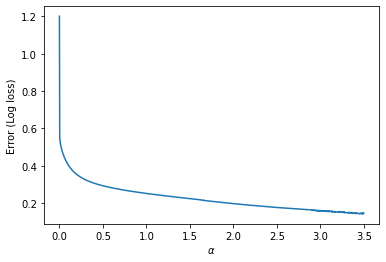

In [129]:
X_st = X.copy()
X_st[2, :] = calc_std_feat(X[2, :])
steps = 1000
err = np.ones(steps)
a1 = 1e-5
a2 = 3.5
for step, alpha in tqdm(enumerate(np.linspace(a1, a2, steps))):
    W, err_ = eval_model(X_st, y, iterations=1000, alpha=alpha)
    err[step] = err_[-1]

s = np.linspace(a1, a2, steps)
plt.plot(s, err)
plt.xlabel(r'$\alpha$')
plt.ylabel('Error (Log loss)')
plt.show()

100it [00:27,  3.58it/s]


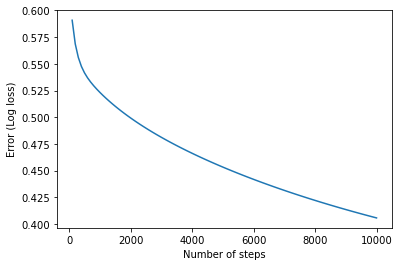

In [130]:
X_st = X.copy()
X_st[2, :] = calc_std_feat(X[2, :])
steps = 100
err = np.ones(steps)
for step, iterations in tqdm(enumerate(np.linspace(1e2, 1e4, steps, dtype=int))):
    W, err_ = eval_model(X_st, y, iterations=iterations, alpha=1e-2)
    err[step] = err_[-1]

s = np.linspace(1e2, 1e4, steps)
plt.plot(s, err)
plt.xlabel('Number of steps')
plt.ylabel('Error (Log loss)')
plt.show()

## 3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [93]:
def calc_pred_proba(W, X):
    """
    Функция вычисления предсказанной вероятности
    
    Parameters:
    ------------
    W - вектор весов
    X - матрица признаков
    """
    return sigmoid(W @ X)

In [94]:
y_pred_proba = calc_pred_proba(eval_model(X_st, y, iterations=1000, alpha=1e-2)[0], X)

## 4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [95]:
def calc_pred(W: np.array, X):
    """
    Функция вычисления предсказанной вероятности
    
    Parameters:
    ------------
    W - вектор весов
    X - матрица признаков
    
    returns:
    y_pred - вектор предсказаний
    """
    y_pred = sigmoid(W @ X)
    y_pred[y_pred >= 1/2] = 1
    y_pred[y_pred < 1/2] = 0

    return y_pred

In [96]:
y_pred = calc_pred(eval_model(X_st, y, iterations=1000, alpha=1e-2)[0], X)

## 5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [85]:
def accur(y, y_pred):
    return ((y-y_pred) == 0).sum() / len(y)

In [98]:
print(accur(y, y_pred))

0.5


In [87]:
def err_matrix(y, y_pred):
    TP = y[(y - y_pred) == 0].sum()
    FP = ((y - y_pred) == -1).sum()
    TN = (y[(y - y_pred) == 0]==0).sum()
    FN = ((y - y_pred) == 1).sum()
    return TP, FP, TN, FN

In [107]:
print(err_matrix(y, y_pred))

(5.0, 5, 0, 0)


In [88]:
def precision(y, y_pred):
    TP, FP, TN, FN = err_matrix(y, y_pred)
    return TP / (TP + FP)

In [108]:
precision(y, y_pred)

0.5

In [89]:
def recall(y, y_pred):
    TP, FP, TN, FN = err_matrix(y, y_pred)
    return TP / (TP + FN)

In [109]:
recall(y, y_pred)

1.0

In [111]:
def f1_score(y, y_pred):
    return round(2 * precision(y, y_pred) * recall(y, y_pred) / (precision(y, y_pred) + recall(y, y_pred)), 4)

In [112]:
f1_score(y, y_pred)

0.6667

## 6. Могла ли модель переобучиться? Почему?

В примере использована маленькая выборка - модель могла переобучится.

## 7*. Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [ ]:
def eval_model_l2(X, y, iterations=1000, alpha=1e-4, lambda_):
    """
    Функция модели логистической регрессии
    
    Params:
    =======
    X - матрица признаков
    y - вектор ответов
    iterations=1000 - количество итераций
    alpha = 1e-4 - скорость обучения
    lambda_ - коэффициент регуляризации
    """
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    err = np.ones(iterations)
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err[i-1] = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T)+ 2 * lambda_ * W)
    if i % (iterations / 10) == 0:
        print(i, W, err)
    return W, err

Не понял какой множитель брать в слагаемом (привычислении W) в l1 регуляризации.